# Project 3 Detecting Sarcopenia
## Francis Yang 1/2/2023
Background:
Age-related loss of skeletal muscle mass and function, defined as sarcopenia, is significantly
related to adverse health outcomes e.g. increased risk of falls and fractures, physical frailty,
mobility limitation, and even premature mortality.
1. Besides, aging, smoking, physical inactivity, malnutrition and chronic comorbid diseases such as hypertension (HT), diabetes mellitus (DM),coronary artery disease (CAD), hyperlipidemia and obesity also have deteriorative effects on muscle mass and function.
2. Prevention of sarcopenia-related morbidity and mortality, among aging people in particular, depends on early detection and treatment, more importantly on unraveling the relationships between muscle loss, decline in muscle function and physical
performance and the aforementioned potential predictor

**Objective: PREDICT IF A PATIENT WILL BE DEVELOPING SARCOPENIA.**

1. **Preprocessing**
    Read the data and print the data information, the shape of the data and explore it. You may need to create new labels for variables such as Education level, Smoking, Gender, Exercise, etc.
2. **Modeling**
    Implement Logistic Regression, Random Forest, and Gradient Boosting on this dataset.
    You might plan to develop two separate models for men and women, as gender plays a significant role in Sarcopenia.
    
You will develop three models:

    * Model 1: Determine the probability that the patient has Sarcopenia based on variables available when the patient is home, such as age, weight, height, exercise, Hypertension, DM, Education, Smoking.. Values for these variables can be obtained without the patient reporting physically to a clinic. At the end of Model 1, diagnose patients with very high probability of developing Sarc as positive and very low probability of Sarc as negative. The remaining patients need further testing, so send them to the next model.
    
    * Model 2: Predict the Sarcopenia probability including CST and GSP. To measure CST, “Chair Stand Test”, a physician times a patient when she sits and stands up on a chair five times. To measure GSP, “Gait speed test”, a physician times a patient when she walks a certain distance. We are provided with these two features in the dataset. In the second model, in addition to the variables we used in the first model, we will include CST and GSP.

    * Model 3: Predict the Sarcopenia including ‘GRS’, Grip Strength Test. A physician measures the grip strength of a patient using a gyro hand grip. We will include GRS into our model with all the variables from Model 2. 
So, in sum, we start with a patient pool, we first eliminate the ones that we are almost certain whether they have Sarcopenia or not. Next, the remaining patients go through Model 2 and we again eliminate the patients that we are almost certain whether they
have Sarcopenia or not. We will repeat the same procedure for Model 3. The remaining
patients after Model 3 will go through ultrasound process to measure their muscle
thickness, which will increase the certainty for diagnosing whether they have
Sarcopenia. Our goal is, making the diagnosis as much as possible and reduce number of
patients going through extra tests.
In your deliverable, report precision, recall, f1, and auc scores. Report feature with a
bar graph.
### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
data = pd.read_csv("datasets/DataSampled.csv")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MMSE                   812 non-null    float64
 1   Age                    1303 non-null   int64  
 2   Weight                 1302 non-null   float64
 3   Height                 1301 non-null   float64
 4   Waist                  1297 non-null   float64
 5   Hip                    1296 non-null   float64
 6   Smoking                1302 non-null   float64
 7   Smoking (packet/year)  1301 non-null   object 
 8   Alcohol                1303 non-null   object 
 9   DM                     1303 non-null   int64  
 10  DM duration            1289 non-null   float64
 11  Insulin                1297 non-null   float64
 12  DM drug                379 non-null    object 
 13  Hyperlipidemia         1301 non-null   float64
 14  Dyslipidemia duration  1287 non-null   float64
 15  Dysl

Column names and missing values shown above. <br>
There are some columns that are intended to be boolean and not int64. They are **Smoking**, **DM**, **Insulin**, **Hyperlipidemia**, **KAH**, **Hypothyroidism**, **KOAH**, **OP**, **HT**.
There are 2 more columns **LowCST** and **Low grip strength** that are boolean, but they seem to be predictors for the actural CST and Grip Strength columns.
#### Missing Data and dType correction

In [3]:
num_na = []
for col in list(data.columns):
    num_na.append(data[col].isna().sum())
col_na = dict(zip(data.columns,num_na))
col_na = pd.Series(col_na)
print("length",len(col_na[col_na>0]))
col_na[col_na>0]

length 32


MMSE                      491
Weight                      1
Height                      2
Waist                       6
Hip                         7
Smoking                     1
Smoking (packet/year)       2
DM duration                14
Insulin                     6
DM drug                   924
Hyperlipidemia              2
Dyslipidemia duration      16
Dyslipidemia drugs       1072
KAH                        42
KAH duration               54
Hypothyroidism             32
ASTIM                     123
KOAH                       78
OP                        948
Other(s)                 1018
Anti-HT drug type         553
HT duration                42
Education                  20
Occupation                 64
Working Status             80
Exercise                   20
LowCST                    190
Gait speed                  3
Low grip strength         137
SARCOPENIA                  1
STAR                        8
BMI                         2
dtype: int64

In [4]:
data['Gender'] = data['Gender'].str.upper()
data['Gender'] = data['Gender'].str.strip()
data['Gender'] = data['Gender'].astype("category")
data['Gender'].value_counts()

F    924
M    379
Name: Gender, dtype: int64

In [5]:
data['SARCOPENIA'] = data['SARCOPENIA'].astype(bool)
data['SARCOPENIA'] = data['SARCOPENIA'].astype("category")
data['SARCOPENIA'].value_counts()

False    1056
True      247
Name: SARCOPENIA, dtype: int64

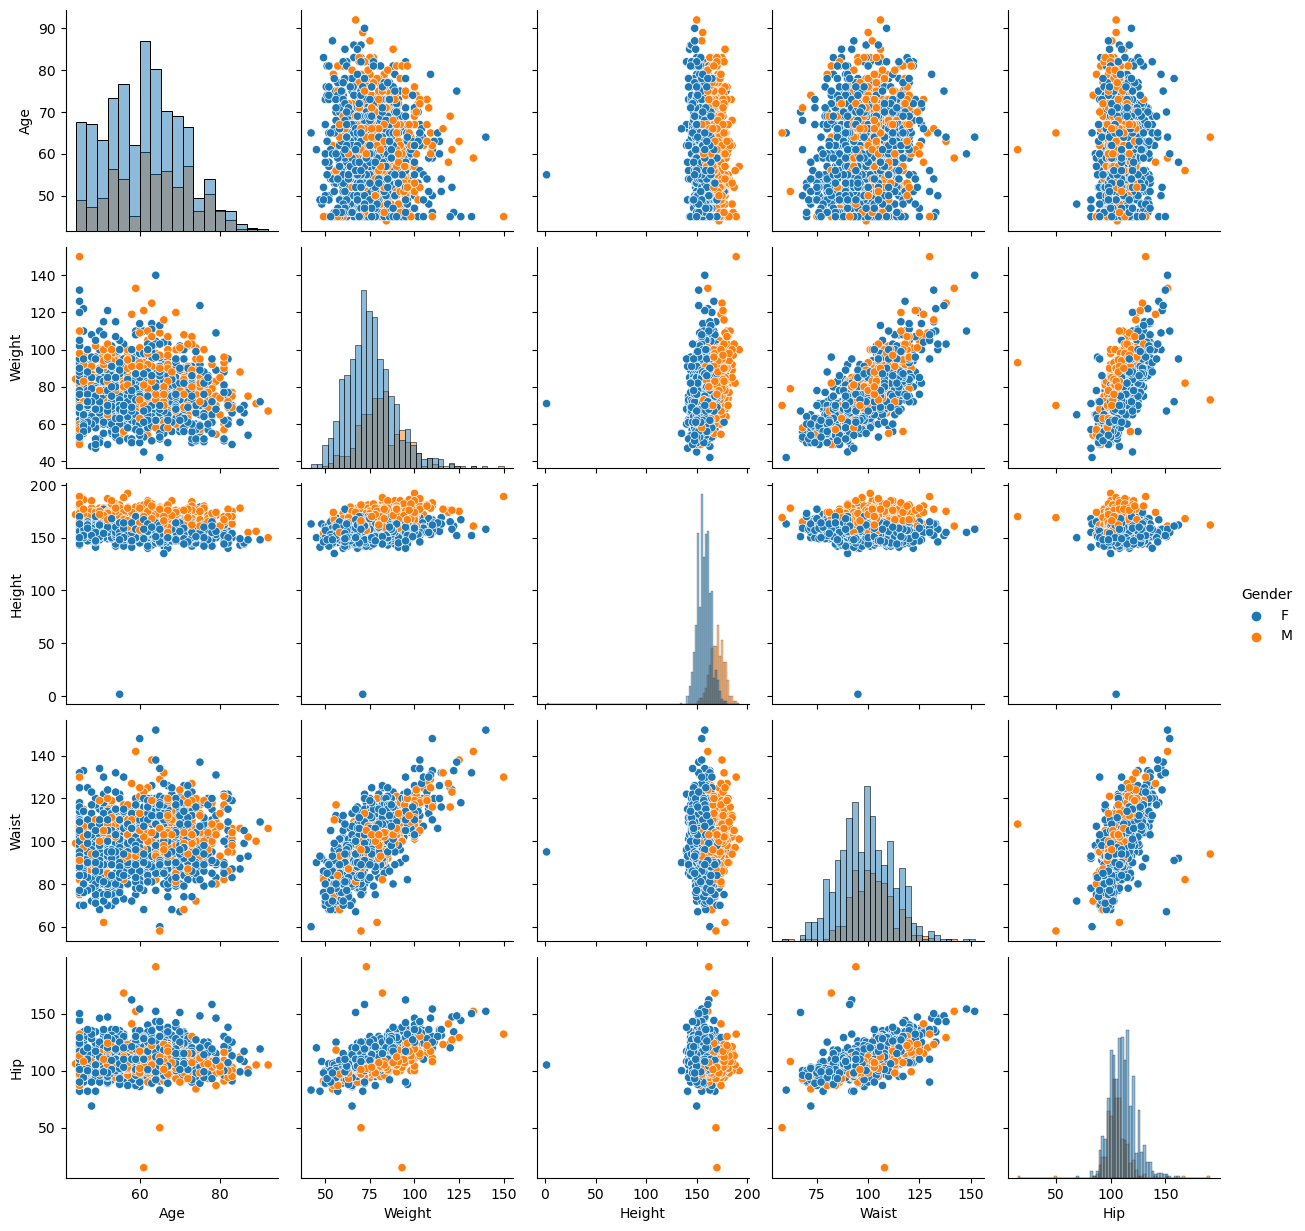

In [6]:
body = data.loc[:,('Age','Weight','Height','Waist','Hip','Gender')]
sns.pairplot(body, hue='Gender', diag_kind="hist")

It is possible to impute the missing values for Weight, Height, etc., based on a linear model, but I'm not going to do that because there are few records missing in each column.

In [7]:
# mean imputation
data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
data['Height'] = data['Height'].fillna(data['Height'].mean())
data['Waist'] = data['Waist'].fillna(data['Waist'].mean())
data['Hip'] = data['Hip'].fillna(data['Hip'].mean())

In [8]:
data['Smoking'] = data['Smoking'].fillna(0)
data['Smoking'] = data['Smoking'].astype('category')

In [9]:
import re


def only_digits(value):
    if re.search('\d{1,3}(?=\/)|\d{1,3}(?=[A-Z])|\d{1,3}(?=\s\()', value):
        obj = re.search('\d{1,3}(?=\/)|\d{1,3}(?=[A-Z])|\d{1,3}(?=\s\()',
                        value)
        return (obj.group())

    elif re.search('(?<=:\s)\d{1,3}$', value):
        obj = re.search('(?<=:\s)\d{1,3}$', value)
        return (obj.group())

    elif re.search('\d{1,3}(?=\syears)', value):
        obj = re.search('\d{1,3}(?=\syears)', value)
        return (obj.group())

    else:
        return (value)


# only apply function on the following query
x = data.loc[(data['Smoking (packet/year)'].str.isnumeric() == False)].index
data.iloc[x, 7] = data.iloc[x, 7].apply(only_digits)

# remaining false querys are all floats
# change column dtype to float64
data['Smoking (packet/year)'] = data['Smoking (packet/year)'].astype(float)

In [10]:
data['Alcohol'] = data['Alcohol'].str.lower()
data['Alcohol'] = data['Alcohol'].astype('category')
data['Alcohol'].value_counts()

0          1127
social      160
regular      16
Name: Alcohol, dtype: int64

In [11]:
data['DM'] = data['DM'].astype(bool)
data['Insulin'] = data['Insulin'].fillna(0)
data['Insulin'] = data['Insulin'].astype(int)

data['LowCST'] = data['LowCST'].astype('category')
data['Low grip strength'] = data['Low grip strength'].astype('category')

In [12]:
data['DM drug'] = data['DM drug'].str.title()
data['DM drug'] = data['DM drug'].str.strip()
print(data['DM drug'].value_counts())

Metformin                                                     150
Metformin, Gliclazide                                          11
Gliclazide                                                     10
Sitagliptin, Metformin                                         10
Insulin                                                         8
                                                             ... 
Empagliflozin,Metformin                                         1
Gliclazide 60, Akarboz 150, Stagliptin 100, Pioglitazon 30      1
Metformin,Gliklazıd,Insulin                                     1
Sitagliptin,Metformin,Gliclazidee                               1
Pioglitazon, Empagliflozin                                      1
Name: DM drug, Length: 160, dtype: int64


In [13]:
#data['num DM drug'] = len(data['DM drug'].str.split())
data['DM drug'] = data['DM drug'].replace('+', ',')
data['DM drug'] = data['DM drug'].replace('/', ',')


def count_drugs(value):
    if type(value) == float:
        # captures Nan values
        return 0

    if value:
        drugs = value.split(',')
        return len(drugs)
    return 0


# create new column
data['num DM drug'] = data['DM drug'].apply(count_drugs)
data['num DM drug'].value_counts()

0    924
1    210
2    100
3     55
4     13
5      1
Name: num DM drug, dtype: int64

Instead of column transforming the **DM drug** column, I will make a new column that groups the number of DM drugs as **num DM drug**. Likewise for **Dyslipidemia drugs**.

In [14]:
data['Dyslipidemia drugs'] = data['Dyslipidemia drugs'].str.title()
data['num Dyslipidemia drugs'] = data['Dyslipidemia drugs'].apply(count_drugs)
data['num Dyslipidemia drugs'].value_counts()

0    1072
1     220
2      11
Name: num Dyslipidemia drugs, dtype: int64

In [15]:
data['Education'] = data['Education'].str.lower()
data['Education'] = data['Education'].fillna('none')
data['Education'].value_counts()

primary school      515
high school         234
illiterate          187
university          183
secondary school    156
none                 23
housewife             4
worker                1
Name: Education, dtype: int64

In [16]:
data['Working Status'] = data['Working Status'].str.lower()
data['Working Status'] = data['Working Status'].fillna('none')
data['Working Status'].value_counts()

retired                     721
unemployed                  180
full-time/part-time work    112
working                      98
none                         82
housewife                    41
full-time work               29
part-time work               23
not working                  12
abstinence                    5
Name: Working Status, dtype: int64

In [17]:
data['Working Status'] = data['Working Status'].replace('not working','retired')

During modeling, there was a problem of column transformer lacking the same categories between test and train sets for Males. Specifically, **not working**, was missing in either set. Therefore the closest category I paired to **retired**.

In [18]:
data['Exercise'] = data['Exercise'].fillna("0")

In [19]:
# check again for nulls
num_na = []
for col in list(data.columns):
    num_na.append(data[col].isna().sum())
col_na = dict(zip(data.columns,num_na))
col_na = pd.Series(col_na)
print("length",len(col_na[col_na>0]))
col_na[col_na>0]

length 22


MMSE                      491
Smoking (packet/year)       2
DM duration                14
DM drug                   924
Hyperlipidemia              2
Dyslipidemia duration      16
Dyslipidemia drugs       1072
KAH                        42
KAH duration               54
Hypothyroidism             32
ASTIM                     123
KOAH                       78
OP                        948
Other(s)                 1018
Anti-HT drug type         553
HT duration                42
Occupation                 64
LowCST                    190
Gait speed                  3
Low grip strength         137
STAR                        8
BMI                         2
dtype: int64

### Data Visualizations

In [20]:
data['MMSE'].isna().value_counts()

False    812
True     491
Name: MMSE, dtype: int64

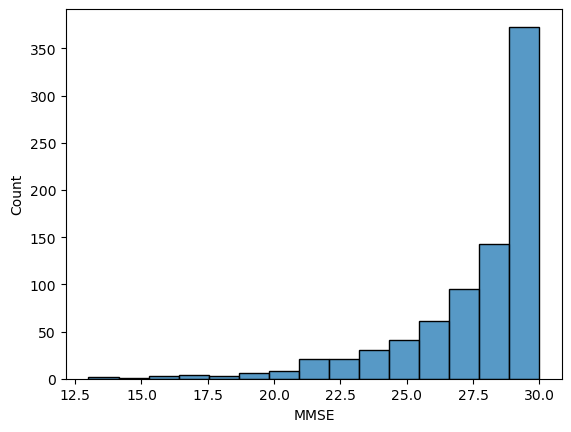

In [21]:
sns.histplot(data=data,x='MMSE', bins=15);

MMSE stands for Mini-Mental State Examination. Maximum points is 30. According to Wikipedia:
```
Any score of 24 or more (out of 30) indicates a normal cognition. Below this, scores can indicate severe (≤9 points), moderate (10–18 points) or mild (19–23 points) cognitive impairment. The raw score may also need to be corrected for educational attainment and age.
```

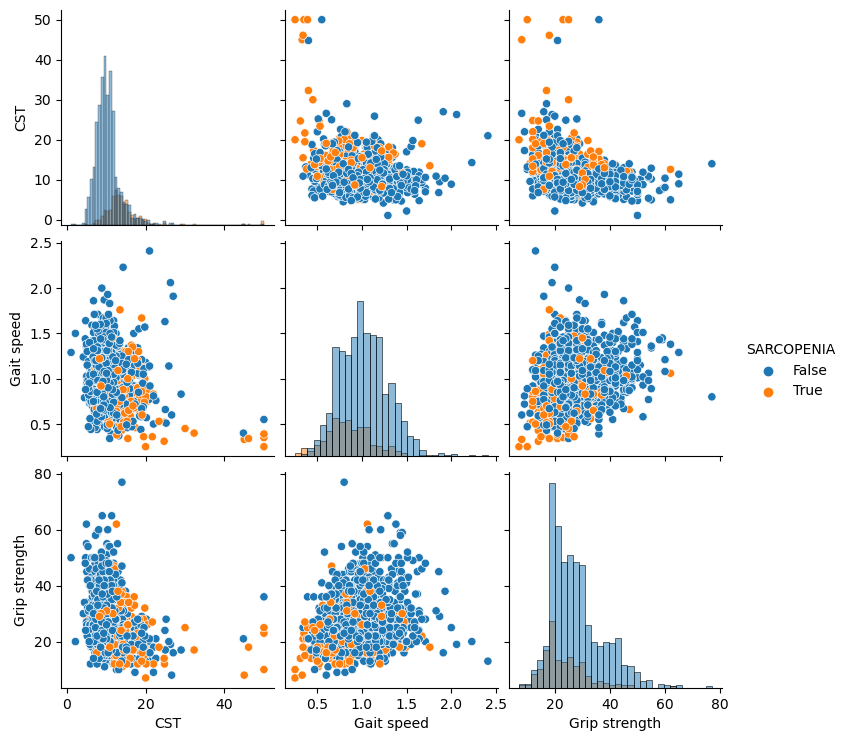

In [22]:
tests = data.loc[:,('LowCST','CST','Gait speed','Low grip strength','Grip strength','Gender','SARCOPENIA')]
sns.pairplot(tests, hue='SARCOPENIA', diag_kind="hist")

#### Variables where imputing makes sense

|        Column         |  dType  |
|-----------------------|---------|
| MMSE                  | float64 |
| Weight                | float64 |
| Height                | float64 |
| Waist                 | float64 |
| Hip                   | float64 |
| Smoking (packet/year) | float64 |
| DM duration           | float64 |
| Dyslipidemia duration | float64 |
| KAH duration          | float64 |
| HT duration           | float64 |
| LowCST                | float64 |
| CST                   | float64 |
| Gait speed            | float64 |
| Low grip strength     | float64 |
| Grip strength         | int64   |
| STAR                  | float64 |
| BMI                   | float64 |

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   MMSE                    812 non-null    float64 
 1   Age                     1303 non-null   int64   
 2   Weight                  1303 non-null   float64 
 3   Height                  1303 non-null   float64 
 4   Waist                   1303 non-null   float64 
 5   Hip                     1303 non-null   float64 
 6   Smoking                 1303 non-null   category
 7   Smoking (packet/year)   1301 non-null   float64 
 8   Alcohol                 1303 non-null   category
 9   DM                      1303 non-null   bool    
 10  DM duration             1289 non-null   float64 
 11  Insulin                 1303 non-null   int32   
 12  DM drug                 379 non-null    object  
 13  Hyperlipidemia          1301 non-null   float64 
 14  Dyslipidemia duration   

 #### Data Split on Gender

In [24]:
from sklearn.preprocessing import LabelEncoder

male = data.loc[data['Gender'] == 'M',
                ('Age', 'Weight', 'Height', 'Hip', 'HT', 'DM', 'Insulin',
                 'Smoking', 'Exercise', 'Alcohol', 'Working Status',
                 'SARCOPENIA')]
female = data.loc[data['Gender'] == 'F',
                  ('Age', 'Weight', 'Height', 'Hip', 'HT', 'DM', 'Insulin',
                   'Smoking', 'Exercise', 'Alcohol', 'Working Status',
                   'SARCOPENIA')]

Xmale = male.drop('SARCOPENIA', axis=1)
Xfemale = female.drop('SARCOPENIA', axis=1)

le = LabelEncoder()
Ymale = male['SARCOPENIA']
Yfemale = female['SARCOPENIA']

Ymale = le.fit_transform(Ymale)
Yfemale = le.fit_transform(Yfemale)

In [25]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


numerical_selector = selector(dtype_exclude=('category',object))
categorical_selector = selector(dtype_include=('category',object))

numerical_columns = numerical_selector(Xmale)    # no need to repeat for female
categorical_columns = categorical_selector(Xmale)# because the same columns used

# Categorical pipeline
categorical_preprocessing = Pipeline([('OrdinalEncoder', OrdinalEncoder())])

# Numeric pipeline
numeric_preprocessing = Pipeline([('Scaling', StandardScaler())])

# Creating preprocessing pipeline
preprocessing = make_column_transformer(
    (numeric_preprocessing, numerical_columns),
    (categorical_preprocessing, categorical_columns)
)

print(numerical_columns, categorical_columns)

['Age', 'Weight', 'Height', 'Hip', 'HT', 'DM', 'Insulin'] ['Smoking', 'Exercise', 'Alcohol', 'Working Status']


In [26]:
from sklearn.model_selection import train_test_split

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Xmale,Ymale, random_state = 6)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(Xfemale,Yfemale, random_state = 4)

### Model 1
*Estimators*: 

| Column | Age | Weight | Height | Hip   | Hypertension | DM  | Education | Smoking | Exercise | Alcohol  | Insulin | Working Status |
|--------|-----|--------|--------|-------|--------------|-----|-----------|---------|----------|----------| -----|--------------|
| dType  | int | float  | float  | float | int          | int | category  | int     | category | category | bool | category|

<br>

*Models*: Logistic Regression, Logistic Regression+PCA, Random Forest, and Gradient Boosting <br>
*Transforms*:<br>
> Column: Exercise, Education, Alcohol

####  Model 1 Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {"C": [1000, 3000], "max_iter": [500, 5000]}

pipe = Pipeline([('preprocessing', preprocessing),
                 ('grid', GridSearchCV(LogisticRegression(), parameters,
                                       cv=5))])

print("\nMale")
pipe.fit(X_train_m, y_train_m)
grid = pipe['grid']
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')

print("\nFemale")
pipe.fit(X_train_f, y_train_f)
grid = pipe['grid']
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')


Male
Best parameters are: {'C': 1000, 'max_iter': 500}
Best score is: 0.7885964912280702

Female
Best parameters are: {'C': 1000, 'max_iter': 500}
Best score is: 0.8311646335105827


#### Model 1 Logistic Regression + PCA

In [28]:
from sklearn.decomposition import PCA

parameters = {"pca__n_components": np.arange(1, 9)}

pipe2 = Pipeline([('preprocessing', preprocessing), ('pca', PCA()),
                  ('model', LogisticRegression(C=1000, max_iter=500))])

print("\nMale")
grid = GridSearchCV(pipe2, parameters, cv=5)
grid.fit(X_train_m, y_train_m)
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')

print("\nFemale")
grid.fit(X_train_f, y_train_f)
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')


Male
Best parameters are: {'pca__n_components': 8}
Best score is: 0.7921679197994987

Female
Best parameters are: {'pca__n_components': 2}
Best score is: 0.8470753831717236


#### Model 1 Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    "n_estimators": [25, 50, 100, 250],
    "max_depth": [4,10]
}
pipe3 = Pipeline([('preprocessing', preprocessing),
                  ('grid', GridSearchCV(RandomForestClassifier(random_state=3), parameters, cv=5))
                  ])

pipe3.fit(X_train_m, y_train_m)
grid = pipe3['grid']
print(f'Best parameters are: {grid.best_params_}')
print("\nMale")
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
print()

pipe3.fit(X_train_f, y_train_f)
grid = pipe3['grid']
print(f'Best parameters are: {grid.best_params_}')
print("\nFemale")
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': 10, 'n_estimators': 25}

Male
0.746 + or -0.036 for the {'max_depth': 4, 'n_estimators': 25}
0.757 + or -0.03 for the {'max_depth': 4, 'n_estimators': 50}
0.753 + or -0.038 for the {'max_depth': 4, 'n_estimators': 100}
0.757 + or -0.027 for the {'max_depth': 4, 'n_estimators': 250}
0.761 + or -0.018 for the {'max_depth': 10, 'n_estimators': 25}
0.746 + or -0.049 for the {'max_depth': 10, 'n_estimators': 50}
0.75 + or -0.038 for the {'max_depth': 10, 'n_estimators': 100}
0.753 + or -0.035 for the {'max_depth': 10, 'n_estimators': 250}

Best parameters are: {'max_depth': 10, 'n_estimators': 25}

Female
0.837 + or -0.01 for the {'max_depth': 4, 'n_estimators': 25}
0.84 + or -0.011 for the {'max_depth': 4, 'n_estimators': 50}
0.844 + or -0.008 for the {'max_depth': 4, 'n_estimators': 100}
0.841 + or -0.009 for the {'max_depth': 4, 'n_estimators': 250}
0.847 + or -0.007 for the {'max_depth': 10, 'n_estimators': 25}
0.841 + or -0.012 for the {'max_depth': 1

#### Model 1 Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

pipe4 = Pipeline([('preprocessing', preprocessing),
                  ('model', GradientBoostingClassifier(n_estimators=100, validation_fraction=0.2,
                                                       n_iter_no_change=5, tol=0.01, random_state=0))
                  ])
pipe4.fit(X_train_m, y_train_m)
accuracy4 = pipe4.score(X_test_m, y_test_m)*100
print(f'GB Model Accuracy: {accuracy4}%')

GB Model Accuracy: 74.73684210526315%


### Model 2
*Estimators*: 

| Column | Model 1 | CST | Gait Speed |
|--------|---------|-----|------------|
| dType  |    ~    |float|    float   |

<br>

*Models*: Logistic Regression, Logistic Regression+PCA, Random Forest, and Gradient Boosting <br>

In [35]:
from sklearn.preprocessing import LabelEncoder

male = data.loc[data['Gender'] == 'M',
                ('Age', 'Weight', 'Height', 'Hip', 'HT', 'DM', 'Insulin',
                 'Smoking', 'Exercise', 'Alcohol', 'Working Status', 'CST',
                 'Gait speed', 'SARCOPENIA')]
female = data.loc[data['Gender'] == 'F',
                  ('Age', 'Weight', 'Height', 'Hip', 'HT', 'DM', 'Insulin',
                   'Smoking', 'Exercise', 'Alcohol', 'Working Status', 'CST',
                   'Gait speed', 'SARCOPENIA')]

Xmale = male.drop('SARCOPENIA', axis=1)
Xfemale = female.drop('SARCOPENIA', axis=1)

le = LabelEncoder()
Ymale = male['SARCOPENIA']
Yfemale = female['SARCOPENIA']

Ymale = le.fit_transform(Ymale)
Yfemale = le.fit_transform(Yfemale)

In [38]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

numerical_selector = selector(dtype_exclude=('category', object))
categorical_selector = selector(dtype_include=('category', object))

numerical_columns = numerical_selector(Xmale)  # no need to repeat for female
categorical_columns = categorical_selector(
    Xmale)  # because the same columns used

# Categorical pipeline
categorical_preprocessing = Pipeline([('OrdinalEncoder', OrdinalEncoder())])

# Numeric pipeline
numeric_preprocessing = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                                  ('Scaling', StandardScaler())
                                ])

# Creating preprocessing pipeline
preprocessing = make_column_transformer(
    (numeric_preprocessing, numerical_columns),
    (categorical_preprocessing, categorical_columns))

print(numerical_columns, categorical_columns)

['Age', 'Weight', 'Height', 'Hip', 'HT', 'DM', 'Insulin', 'CST', 'Gait speed'] ['Smoking', 'Exercise', 'Alcohol', 'Working Status']


In [39]:
from sklearn.model_selection import train_test_split

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Xmale,Ymale, random_state = 6)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(Xfemale,Yfemale, random_state = 4)

#### Model 2 Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {"C": [1000, 3000], "max_iter": [500, 5000]}

pipe = Pipeline([('preprocessing', preprocessing),
                 ('grid', GridSearchCV(LogisticRegression(), parameters,
                                       cv=5))])

print("\nMale")
pipe.fit(X_train_m, y_train_m)
grid = pipe['grid']
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')

print("\nFemale")
pipe.fit(X_train_f, y_train_f)
grid = pipe['grid']
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')


Male
Best parameters are: {'C': 1000, 'max_iter': 500}
Best score is: 0.7990601503759398

Female
Best parameters are: {'C': 1000, 'max_iter': 500}
Best score is: 0.8455948284850381


#### Model 2 Logistic Regression + PCA

In [41]:
from sklearn.decomposition import PCA

parameters = {"pca__n_components": np.arange(1, 9)}

pipe2 = Pipeline([('preprocessing', preprocessing), ('pca', PCA()),
                  ('model', LogisticRegression(C=1000, max_iter=500))])

print("\nMale")
grid = GridSearchCV(pipe2, parameters, cv=5)
grid.fit(X_train_m, y_train_m)
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')

print("\nFemale")
grid.fit(X_train_f, y_train_f)
print(f'Best parameters are: {grid.best_params_}')
print(f'Best score is: {grid.best_score_}')


Male
Best parameters are: {'pca__n_components': 5}
Best score is: 0.8202380952380952

Female
Best parameters are: {'pca__n_components': 2}
Best score is: 0.8528307788551768


#### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    "n_estimators": [25, 50, 100, 250],
    "max_depth": [4,10]
}
pipe3 = Pipeline([('preprocessing', preprocessing),
                  ('grid', GridSearchCV(RandomForestClassifier(random_state=3), parameters, cv=5))
                  ])

pipe3.fit(X_train_m, y_train_m)
grid = pipe3['grid']
print(f'Best parameters are: {grid.best_params_}')
print("\nMale")
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
print()

pipe3.fit(X_train_f, y_train_f)
grid = pipe3['grid']
print(f'Best parameters are: {grid.best_params_}')
print("\nFemale")
mean_score = grid.cv_results_['mean_test_score']
std_score = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, std, params in zip(mean_score, std_score, params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': 4, 'n_estimators': 250}

Male
0.824 + or -0.043 for the {'max_depth': 4, 'n_estimators': 25}
0.834 + or -0.051 for the {'max_depth': 4, 'n_estimators': 50}
0.838 + or -0.052 for the {'max_depth': 4, 'n_estimators': 100}
0.841 + or -0.047 for the {'max_depth': 4, 'n_estimators': 250}
0.81 + or -0.041 for the {'max_depth': 10, 'n_estimators': 25}
0.81 + or -0.045 for the {'max_depth': 10, 'n_estimators': 50}
0.82 + or -0.046 for the {'max_depth': 10, 'n_estimators': 100}
0.813 + or -0.034 for the {'max_depth': 10, 'n_estimators': 250}

Best parameters are: {'max_depth': 4, 'n_estimators': 25}

Female
0.859 + or -0.007 for the {'max_depth': 4, 'n_estimators': 25}
0.854 + or -0.007 for the {'max_depth': 4, 'n_estimators': 50}
0.853 + or -0.008 for the {'max_depth': 4, 'n_estimators': 100}
0.851 + or -0.012 for the {'max_depth': 4, 'n_estimators': 250}
0.844 + or -0.014 for the {'max_depth': 10, 'n_estimators': 25}
0.856 + or -0.006 for the {'max_depth': 1

#### Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

pipe4 = Pipeline([('preprocessing', preprocessing),
                  ('model', GradientBoostingClassifier(n_estimators=100, validation_fraction=0.2,
                                                       n_iter_no_change=5, tol=0.01, random_state=0))
                  ])
pipe4.fit(X_train_m, y_train_m)
accuracy4 = pipe4.score(X_test_m, y_test_m)*100
print(f'GB Model Accuracy: {accuracy4}%')

GB Model Accuracy: 81.05263157894737%
